<a href="https://colab.research.google.com/github/CoderSsVartak/Image-Reconstruction/blob/master/image_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Total epochs = 100, batch_size = 16
# T1 = 2700, T2 = 300, T3 = 12,000
# 1st 18 epochs, train generator only using MSE loss. next 2 epochs, train only discriminator using discriminator loss
# Remaining 80 epochs, train both using generator and discriminator loss
# Increase training set to 600 images, test set to 30 images and reduce percent mask to 50%, 

import os
import time
import random
import datetime
import pytz

#Image manipulation packages
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from skimage.util import random_noise

#Tensorflow models libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Conv2DTranspose, Flatten, Dense, Dropout, LeakyReLU
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.applications import VGG19

#Alternative of pickle for larger files
import joblib
import pickle

#packages required to get the data uploaded on the drive
from googleapiclient.http import MediaIoBaseDownload
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from googleapiclient.discovery import build
from google.colab import drive
import io
import random

In [2]:
# Google Drive API Code to authenticate access to your google acount drive that has the dataset in it
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
#Code to load images from Drive
def load_drive_data(file_id):

    drive_service = build('drive', 'v3')
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()

    downloaded.seek(0)

    # Joblib is used because of large file size
    f = joblib.load(downloaded)

    return f

#images downloaded are in the form of a dictionary, convert it to a numpy array
def dict_to_array(images):

    image_list = []
    for persons in images.keys():
        image_list.append(images[persons])
    
    return np.array(image_list)

#function to plot multiple images
def plot(images, figsize=(10, 10)):

    plt.figure(figsize=figsize)
    
    for index, image in enumerate(images):
        # display original
        ax = plt.subplot(2, len(images), index + 1)
        plt.imshow(image.reshape(image.shape[0], image.shape[1], image.shape[2]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


In [4]:
def augment_data(images):
    
    temp_images = []
    for image in images:

        # Rotate the image Left to right
        temp_images.append(np.fliplr(image))

        temp_images.append(np.flipud(image))
        # Add Gaussian noise to the image
        # var = random.uniform(0, 0.01)
        # temp_images.append(random_noise(image, var=var))
        
        # # Blur the image
        # temp_images.append(cv2.GaussianBlur(image, (7, 7), 0))
    
    return np.concatenate((images, temp_images))


In [5]:
# images obtained are in the form of a dictionary and have values between 0-1, and are cropped so as to obtain just the facial images
# dictionary[person] = image_value

# Data description: Total facial images of 105 people with each person having a total of 6 images
# Input given is the file id of the file stored in drive
data_key = '1QZv7mWvvF8mnT0A2mA4OFSvxF1eqPd8g'

image_data = load_drive_data(data_key)
images = dict_to_array(image_data)

# Create data copy to local storage, can be accessed directly from there
with open('image_data.pickle', 'wb') as file:
    joblib.dump(images, file)

In [31]:
# Load the test set images required
with open('/content/image_data.pickle', 'rb') as file:
    images = joblib.load(file)

In [6]:
# Code to crop the image's rows so as to center the images
image_size, percent_crop = 224, 0.15
total_images = 600
start_point = int(image_size*percent_crop)
end_point = image_size-start_point

# Training dataset
train_images = images[0: total_images, start_point: end_point, start_point: end_point, :]
test_images = images[total_images: , start_point: end_point, start_point: end_point, :]
# Data augmentation
try:
    del(image_data)
except NameError:
    pass
train_images = augment_data(train_images)
test_images = augment_data(test_images)

In [7]:
images.shape, train_images.shape, test_images.shape

((630, 224, 224, 3), (1800, 158, 158, 3), (90, 158, 158, 3))

In [8]:
# Block a % of image visible
# percent_mask is in the range 0 - 1
def create_masked_images(images, **kwargs):

    mask_shape = images.shape

    # default value for percentage of image to be masked
    percent_mask = 0.5
    if 'percent_mask' in kwargs:
        percent_mask = kwargs['percent_mask']

    # hide_axis = 2 => row axis
    hide_axis = 2
    if 'hide_axis' in kwargs:
        hide_axis = kwargs['hide_axis']
    
    # Always the 2nd axis ie columns are masked
    zero_shape = int(mask_shape[hide_axis]*percent_mask)//2
    one_shape = mask_shape[hide_axis] - zero_shape*2

    # Return only the central portion of the image
    if 'partial_image' in kwargs:

        print("Hidden pixels and Visible Pixels Count: ",zero_shape, one_shape)
        # print(images[:, :, zero_shape: one_shape+zero_shape, :].shape)
        return images[:, :, zero_shape: one_shape+zero_shape, :]
    
    if hide_axis == 1:
        zero_shape = (mask_shape[0], zero_shape, mask_shape[2], 1)
        one_shape = (mask_shape[0], one_shape, mask_shape[2], 1)
    
    else:
        zero_shape = (mask_shape[0], mask_shape[1], zero_shape, 1)
        one_shape = (mask_shape[0], mask_shape[1], one_shape, 1)

    mask = np.concatenate((np.zeros(zero_shape), np.ones(one_shape), np.zeros(zero_shape)), axis=hide_axis)
    
    if 'show_boundary' in kwargs and kwargs['show_boundary']:
        mask_compliment = 1 - mask
        
        temp_images, new_mask = [], []
        for index, image in enumerate(images):
            new_mask.append(mask[index] + np.mean(image)*mask_compliment[index])
            temp_images.append(mask[index]*image + np.mean(image)*mask_compliment[index])

        return np.array(temp_images), np.array(new_mask)

    return mask*images, mask[0]


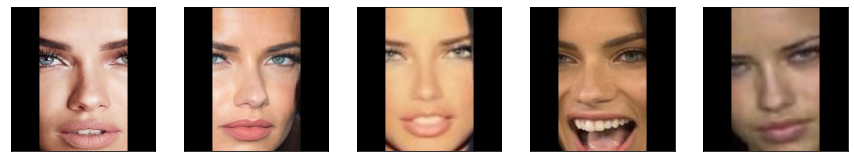

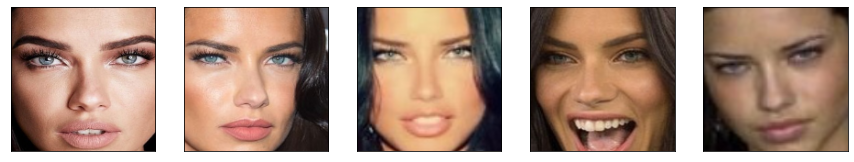

In [ ]:
plot(create_masked_images(images[0: 5], percent_mask = 0.3, hide_axis=2)[0], figsize=(15, 15))
plot(images[0: 5], figsize=(15, 15))
psnr(images[0: 5], create_masked_images(images[0: 5], percent_mask = 0.3, hide_axis=2)[0])

In [ ]:
# Initially 60% image is masked, 530 for training and 100 for testing.
# Reduce masking size if network doesnt optimize

In [9]:
masked_images, masks = create_masked_images(train_images, percent_mask = 0.4, hide_axis=2, show_boundary=True)
masked_test, masks_test = create_masked_images(test_images, percent_mask = 0.4, hide_axis=2, show_boundary=True)

# Combine the images with their mask (158, 158, 3) => (158, 158, 4)
masked_images = np.concatenate((masked_images, masks), axis=3)
masked_test = np.concatenate((masked_test, masks_test), axis=3)

In [10]:
masked_images.shape, masks.shape, masked_test.shape, masks_test.shape

((1800, 158, 158, 4),
 (1800, 158, 158, 1),
 (90, 158, 158, 4),
 (90, 158, 158, 1))

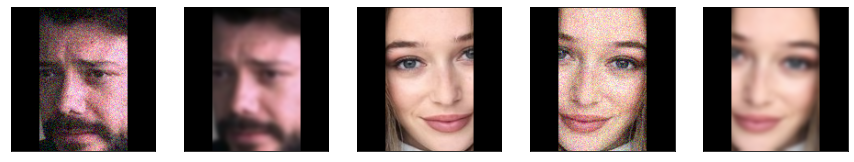

In [ ]:
start, end = 700, 705
plot(masked_images[start: end], figsize=(15, 15))

In [57]:
# https://towardsdatascience.com/hitchhikers-guide-to-residual-networks-resnet-in-keras-385ec01ec8ff

def image_generator(image_shape, dropout=False):

    input_img = Input(shape=image_shape, dtype='float32')

    x = Conv2D(64, (5, 5), strides=1, dilation_rate=(1, 1), activation='relu', padding='same')(input_img)
    if dropout:
        x = Dropout(0.4)(x)

    x = Conv2D(128, (3, 3), strides=2, dilation_rate=(1, 1), activation='relu', padding='same')(x)
    if dropout:
        x = Dropout(0.4)(x)
    
    x = Conv2D(256, (3, 3), strides=1, dilation_rate=(1, 1), activation='relu', padding='same')(x)
    if dropout:
        x = Dropout(0.4)(x)

    x = Conv2D(256, (3, 3), strides=1, dilation_rate=(2, 2), activation='relu', padding='same')(x)
    if dropout:
        x = Dropout(0.4)(x)

    x = Conv2D(256, (3, 3), strides=1, dilation_rate=(4, 4), activation='relu', padding='same')(x)
    if dropout:
        x = Dropout(0.4)(x)

    x = Conv2D(256, (3, 3), strides=1, dilation_rate=(8, 8), activation='relu', padding='same')(x)
    if dropout:
        x = Dropout(0.4)(x)

    x = Conv2D(256, (3, 3), strides=1, dilation_rate=(1, 1), activation='relu', padding='same')(x)
    if dropout:
        x = Dropout(0.4)(x)

    x = Conv2DTranspose(256, (4, 4), strides=2, dilation_rate=(1, 1), activation='relu', padding='same')(x)

    x = Conv2D(64, (3, 3), strides=1, dilation_rate=(1, 1), activation='relu', padding='same')(x)

    x = Conv2D(3, (3, 3), strides=1, dilation_rate=(1, 1), activation='relu', padding='same')(x)

    return Model(input_img, x, name='Generator')


def image_discriminator(image_shape):

    input_img = Input(shape=image_shape, dtype='float32')

    x = Conv2D(32, (5, 5), strides=2, activation='relu', padding='same')(input_img)
    x = Conv2D(64, (5, 5), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(128, (5, 5), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(128, (5, 5), strides=2, activation='relu', padding='same')(x)
    x = Conv2D(64, (5, 5), strides=2, activation='relu', padding='same')(x)
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dense(1, activation='sigmoid')(x)

    return Model(input_img, x, name='Discriminator')


    

In [58]:
gen_model = image_generator((None, None, 4), dropout=True)
gen_model.summary()

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, None, None, 4)]   0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, None, None, 64)    6464      
_________________________________________________________________
dropout_13 (Dropout)         (None, None, None, 64)    0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, None, None, 128)   73856     
_________________________________________________________________
dropout_14 (Dropout)         (None, None, None, 128)   0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, None, None, 256)   295168    
_________________________________________________________________
dropout_15 (Dropout)         (None, None, None, 256)   0 

In [59]:
disc_model = image_discriminator(image_shape=(158, 158, 3))
disc_model.summary()

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 158, 158, 3)]     0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 79, 79, 32)        2432      
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 40, 40, 64)        51264     
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 20, 20, 128)       204928    
_________________________________________________________________
conv2d_75 (Conv2D)           (None, 10, 10, 128)       409728    
_________________________________________________________________
conv2d_76 (Conv2D)           (None, 5, 5, 64)          204864    
_________________________________________________________________
flatten_4 (Flatten)          (None, 1600)            

In [14]:
# Loss functions

def mse(y_true, y_pred):
    return tf.reduce_mean(tf.losses.mean_squared_error(y_true, y_pred))

def cosine_sim(y_true, y_pred):
    return tf.reduce_mean(tf.abs(tf.losses.cosine_similarity(tf.cast(y_true, tf.float32), tf.cast(y_pred, tf.float32))))

# y_true is the output of the discriminator for actual images
# y_pred is the output of the discriminator for generator generated images

def discriminator_loss(y_true, y_pred, epsilon=1e-7):
    return -tf.reduce_mean(tf.math.log(tf.maximum(y_true, epsilon)) + tf.math.log(tf.maximum(1-y_pred, epsilon)))


# y_true is the actual image
# y_pred is the Generator generated image
# discriminator_pred is the output of the discriminator when given image generated by the generator
# alpha is used as a control variable to determine the importance of mse loss
def generator_loss(y_true, y_pred, discriminator_pred, mask_compliment, alpha=0.0004, epsilon=1e-7):
    return mse(y_true, y_pred) - alpha*tf.reduce_mean(tf.math.log(tf.maximum(discriminator_pred, epsilon)))


#Tensorflow function to find psnr and rmse of an image
def psnr(y_true, y_pred):
    return tf.math.reduce_mean(tf.image.psnr(y_true, y_pred, max_val=1, name=None))

def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean((y_true - y_pred)**2))



In [15]:
def save_models(generator, discriminator, gen_filename='', disc_filename=''):

    save_model(generator, gen_filename)
    save_model(discriminator, disc_filename)


# To save the new logs
def save_logs(logs, previous_logs=None, logfile_name='', keys=None):

    temp = {}
    if previous_logs and keys:

        for key in keys:
            temp[key] = previous_logs[key] + logs[key]
    
    else:
        temp = logs
    
    with open(logfile_name, 'wb') as file:
        pickle.dump(temp, file)
    
    return True
        
# Load the logfile
def load_logs(logfile_name=None):

    if logfile_name:
        try:
            with open(logfile_name, 'rb') as file:
                temp_logs = pickle.load(file)

            print("Log file loaded in the form of a dictionary")

            return temp_logs

        except FileNotFoundError:
            print("No log file created, Returned an empty dictionary")
            return {}
            
    return False

In [16]:
# https://keras.io/guides/writing_a_training_loop_from_scratch/
# pass pre compiled generator and discriminator models as input to the function

# kwargs can contain train_data = (masked_images, actual_images), test_data = (masked_test, actual_test),
#                    epochs, batch_size, 
#                    train_disc_after,
#                    loss=(gen_loss_function, disc_loss_function),
#                    optimizer = (gen_optimizer, disc_optimizer)
#                    mask_compliment, accuracy_function,
#                    save_after, save_model

def train(gen_model, disc_model, **kwargs):

    test_present = True if 'test_data' in kwargs else False

    if 'train_data' in kwargs:
        masked_images, actual_images = kwargs['train_data'][0], kwargs['train_data'][1]

    if 'test_data' in kwargs:
        masked_test, actual_test = kwargs['test_data'][0], kwargs['test_data'][1]  

    # Default epoch count
    epochs, epochs_done = 100, 0
    if 'epochs' in kwargs:
        total_epochs, phase_1, phase_2  = kwargs['epochs']
        epochs_done = kwargs['epochs_done']
    
    # Default batch_size value
    batch_size = 32
    if 'batch_size' in kwargs:
        batch_size = kwargs['batch_size']

    if 'loss' in kwargs:
        gen_loss_function, disc_loss_function = kwargs['loss'][0], kwargs['loss'][1]

    if 'optimizer' in kwargs:
        gen_optimizer, disc_optimizer = kwargs['optimizer'][0], kwargs['optimizer'][1]
    
    if 'mask_compliment' in kwargs:
        mask_compliment = kwargs['mask_compliment']
    
    if 'metric' in kwargs:
        accuracy = kwargs['metric']

    if 'mse' in kwargs:
        mse_error = kwargs['mse']
    
    save_after = 10
    if 'save_after' and 'save_models' in kwargs:
        save_after = kwargs['save_after']
        save = kwargs['save_models']
        
    if 'history' and 'save_logs' in kwargs:
        history = kwargs['history']
        save_logs = kwargs['save_logs']
        

    # List to store the loss and accuracy values after each epochs
    global gen_losses, disc_losses, test_gen_losses, test_disc_losses
    global gen_accuracy, test_gen_accuracy
    global temp_history

    gen_losses, disc_losses, gen_accuracy, temp_history = [], [], [], {}
    test_gen_losses, test_disc_losses, test_gen_accuracy = [], [], []
    
    # Shuffle dataset only once
    masked_images, actual_images = shuffle(masked_images, actual_images)
    # Train for desired number of epochs
    for step in range(total_epochs-epochs_done):
        
        # Shuffle the dataset at the start of each epoch
        # masked_images, actual_images = shuffle(masked_images, actual_images)

        # Print which phase is the training going on
        if epochs_done + step == 0:
            print("----------------Starting Phase 1----------------")
        elif epochs_done + step == phase_1:
            print("----------------Starting Phase 2----------------")
        elif epochs_done + step == phase_1 + phase_2:
            print("----------------Starting Phase 3----------------")

        print(f'Epoch {epochs_done+step+1}/{total_epochs}', end='\n[')
        start_time = time.time()

        # Generator & Discriminator Loss and accuracy trackers for each epochs
        gen_loss, gen_acc = 0, 0
        disc_loss = 0

        # Loss alters after phase 1, so variable to change the name of the loss 
        gen_loss_name = 'MSE'
        if epochs_done + step >= phase_1:
            gen_loss_name = 'altered_MSE'

            
        # train on batch data
        batch_steps = masked_images.shape[0]//batch_size
        for batch_step in range(batch_steps):
            
            # Generator & Discriminator Loss and accuracy trackers for each batch
            gen_batch_loss, disc_batch_loss = 0, 0
            gen_batch_acc = 0
            start, end = batch_step*batch_size, (batch_step+1)*batch_size
            
            with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
                
                # Generator applied to masked images
                gen_train = gen_model(masked_images[start: end], training=True)
                
                # Discriminator makes prediction on both masked and actual images
                y_pred = disc_model(gen_train, training=True)
                y_true = disc_model(actual_images[start: end], training=True)
                
                # Uncomment these lines if binary crossentropy loss is to be used
                # y_true = tf.concat([tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0)
                # y_pred = tf.concat([y_pred, y_true], axis=0)

                # Generator accuracy
                gen_batch_acc = accuracy(actual_images[start: end], gen_train)

                # Phase 1: Compute Loss for both Generator and Discriminator
                if epochs_done + step < phase_1:
                    gen_batch_loss = mse_error(actual_images[start: end], gen_train)
                    disc_batch_loss = tf.reduce_mean(disc_loss_function(y_true, y_pred))
                
                # Phase 2: Compute loss for both Generator and Discriminator
                elif epochs_done + step < phase_1 + phase_2:
                    gen_batch_loss = mse_error(actual_images[start: end], gen_train)
                    disc_batch_loss = tf.reduce_mean(disc_loss_function(y_true, y_pred))

                # Phase 3: Computer altered loss for Generator and loss for Discriminator
                else:
                    # Find out loss for phase 3
                    gen_batch_loss = gen_loss_function(actual_images[start: end], gen_train, y_pred, mask_compliment)
                    disc_batch_loss = tf.reduce_mean(disc_loss_function(y_true, y_pred))

                # Add batch loss to the epoch loss
                gen_loss += gen_batch_loss
                disc_loss += disc_batch_loss    
                gen_acc += gen_batch_acc
            

            # Phase 1: Train only Generator on MSE loss
            if epochs_done + step < phase_1:
                gen_grads = gen_tape.gradient(gen_batch_loss, gen_model.trainable_weights)
                gen_optimizer.apply_gradients(zip(gen_grads, gen_model.trainable_weights))

            # Phase 2: Train only Discriminator
            elif epochs_done + step < phase_1 + phase_2:
                disc_grads = disc_tape.gradient(disc_batch_loss, disc_model.trainable_weights)
                disc_optimizer.apply_gradients(zip(disc_grads, disc_model.trainable_weights))
            
            # Phase 3: Train both Generator and Discriminator, Generator -> Altered_MSE losss
            else:
                gen_grads = gen_tape.gradient(gen_batch_loss, gen_model.trainable_weights)
                gen_optimizer.apply_gradients(zip(gen_grads, gen_model.trainable_weights))
                

                if 'train_disc_after' in kwargs:
                    if batch_step % kwargs['train_disc_after'] == 0:
                        disc_grads = disc_tape.gradient(disc_batch_loss, disc_model.trainable_weights)
                        disc_optimizer.apply_gradients(zip(disc_grads, disc_model.trainable_weights))
                        
                
                else:
                    disc_grads = disc_tape.gradient(disc_batch_loss, disc_model.trainable_weights)
                    disc_optimizer.apply_gradients(zip(disc_grads, disc_model.trainable_weights))
                    

            if batch_step % 20 == 0:
                print('=', end='')
        
        print(']', end='  ')
        # Add mean of batch_losses into loss_list
        gen_losses.append(gen_loss/batch_steps)
        disc_losses.append(disc_loss/batch_steps)

        # Add mean of batch accuracy into accuracy list
        gen_accuracy.append(gen_acc/batch_steps)

        # Calculate the time elapsed for the total epoch
        elapsed_time = time.time() - start_time
        
        # Validation dataset
        if 'test_data' in kwargs:
            test_gen_pred = gen_model(masked_test, training=False)
            
            test_pred = disc_model(test_gen_pred)
            test_true = disc_model(actual_test)
            
            # Uncomment if binary crossentropy loss is to be used
            # zeros, ones = tf.zeros((masked_test.shape[0], 1)), tf.ones((actual_test.shape[0], 1))
            # test_true, test_pred = tf.concat([zeros, ones], axis=0), tf.concat([test_pred, test_true], axis=0)

            test_psnr = accuracy_function(actual_test, test_gen_pred)

            # Compute Test loss for Generator
            if epochs_done + step < phase_1 + phase_2:
                test_gen_loss = mse_error(actual_test, test_gen_pred)
            else:
                test_gen_loss = gen_loss_function(actual_test, test_gen_pred, test_pred, mask_compliment)

            # Compute Test loss for Discriminator
            test_disc_loss = tf.reduce_mean(disc_loss_function(test_true, test_pred))

            # Append losses to the loss list
            test_gen_losses.append(test_gen_loss)
            test_disc_losses.append(test_disc_loss)
            test_gen_accuracy.append(test_psnr)
            
            # print Metrics
            print(f'{gen_loss_name} = {gen_loss/batch_steps:.4f}, Disc Loss = {disc_loss/batch_steps:.4f}, PSNR = {gen_acc/batch_steps:.3f}, Test {gen_loss_name} = {test_gen_loss:.4f}, Test Disc Loss = {test_disc_loss:.4f}, Test PSNR = {test_psnr:.3f} ')    

        else:
            print(f'{gen_loss_name} = {gen_loss/batch_steps:.4f}, Disc Loss = {disc_loss/batch_steps:.4f}, PSNR = {gen_acc/batch_steps:.3f}')

        print(f'Time per epoch: {time.strftime("%H:%M:%S", time.gmtime(elapsed_time))}')
        print()

        # save the models and the log files
        if step % save_after == 0 or epochs_done + step == total_epochs-1:

            save_model(gen_model, f'Generator_{step+1+epochs_done}epochs.h5', include_optimizer=True, save_format='h5')
            save_model(disc_model, f'Discriminator_{step+1+epochs_done}epochs.h5', include_optimizer=True, save_format='h5')
            
            # save(gen_model, disc_model,
            #      gen_filename=f'Generator_{step+1+epochs_done}epochs.h5', 
            #      disc_filename=f'Discriminator_{step+1+epochs_done}epochs.h5')

            if 'history' in kwargs:
                
                # If there are no keys in the logfile
                if history == {}:
                    keys = ['generator_losses', 'disc_losses', 'psnr']
                    
                    if test_present:
                        keys.append('test_generator_losses')
                        keys.append('test_discriminator_losses')
                        keys.append('test_psnr')
                
                else:
                    keys = history.keys()

                if test_present:
                    save_logs(logs={'generator_loss': gen_losses, 'discriminator_loss':disc_losses, 'psnr':gen_accuracy,
                                    'test_generator_loss':test_gen_losses, 'test_discriminator_loss':test_disc_losses, 'test_psnr':test_gen_accuracy},
                            previous_logs=history,
                            logfile_name=f'logs_{step+1+epochs_done}epochs.pickle',
                            keys=keys)

                else:
                    save_logs(logs={'generator_loss': gen_losses, 'discriminator_loss':disc_losses, 'psnr':gen_accuracy},
                              previous_logs=history,
                              logfile_name=f'logs_{step+1+epochs_done}epochs.pickle',
                              keys=keys)

                    
                # Update current logs
                history = load_logs(logfile_name=f'logs_{step+1+epochs_done}epochs.pickle')

                # Reset the losses as they are being saved to avoid repeatation
                gen_losses, disc_losses, gen_accuracy = [], [], []
                test_gen_losses, test_disc_losses, test_gen_accuracy = [], [], []

        # Display the first 4 examples and its metrics
        if 'plot_function' in kwargs and 'plot_after' in kwargs and step % kwargs['plot_after'] == 0:

            print("Test Images")
            kwargs['plot_function'](np.array(test_gen_pred[: 4]), figsize=(15, 15))
                    
            print("Masked Images")
            kwargs['plot_function'](np.array(masked_test[: 4]), figsize=(15, 15))

            print("Actual Images")
            kwargs['plot_function'](np.array(actual_test[: 4]), figsize=(15, 15))

            print(f"PSNR: {psnr(actual_test[: 4], test_gen_pred[: 4])}")
            print(f"MSE: {mse(actual_test[: 4], test_gen_pred[: 4])}")
            print(f'RMSE: {rmse(actual_test[: 4], test_gen_pred[: 4])}')
            print(f'Cosine Similarity: {cosine_sim(actual_test[: 4], test_gen_pred[: 4])}')
            print(f'Discriminator Prediction on Generator: {tf.reduce_mean(disc_model.predict(test_gen_pred[: 4]))}')
            print(f'Discriminator Prediction on Actual: {tf.reduce_mean(disc_model.predict(actual_test[: 4]))}')

            del test_gen_pred
            del test_pred
            del test_true

            
    
    

In [60]:
# Common parameters for generator and discriminator

# metrics = [tf.metrics.RootMeanSquaredError]
batch_size = 8
lr_rate = 0.0001
epochs = (80, 15, 0)
epochs_done = 0
epsilon = 1e-7
save_after = 80
train_disc_after = 1
plot_after = 3

# Comment the lr_schedule, gen_optimizer and disc_optimizer if model is to be reloaded
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(learning_rate,
#                                                              decay_steps=10000, 
#                                                              decay_rate=0.96,
#                                                              staircase=True)

gen_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_rate, beta_1 = 0.4, beta_2=0.999, epsilon=epsilon)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=lr_rate, beta_1 = 0.4, beta_2=0.999, epsilon=epsilon)

gen_loss = generator_loss
disc_loss = discriminator_loss
mse_error = mse


loss = (gen_loss, disc_loss)
accuracy_function = psnr

logs = load_logs(logfile_name=f'logs_{epochs_done}epochs.pickle')
print("Keys in Dictionary: ", logs.keys())
try:
    print("Length: ", len(logs['generator_loss']))
except KeyError:
    pass

No log file created, Returned an empty dictionary
Keys in Dictionary:  dict_keys([])


In [19]:
mask_compliment = 1 - masks

train_data = (masked_images, train_images)
test_data = (masked_test, test_images)

del images
del masked_images
del masks
del train_images
del test_images
del masked_test

In [ ]:
epochs_done = 10

In [61]:
# Run this cell only if the model is to be trained from the beginning
gen_model.compile(optimizer=gen_optimizer, loss=gen_loss)
disc_model.compile(optimizer=disc_optimizer, loss=disc_loss)

In [ ]:
gen_model = load_model('/Generator_31epochs.h5', custom_objects={'generator_loss': gen_loss})
disc_model = load_model('/Discriminator_31epochs.h5', custom_objects={'discriminator_loss':disc_loss})

gen_optimizer = gen_model.optimizer
disc_optimizer = disc_model.optimizer

----------------Starting Phase 1----------------
Epoch 1/80
[============]  MSE = 0.0441, Disc Loss = 1.3862, PSNR = 14.303, Test MSE = 0.1053, Test Disc Loss = 1.3949, Test PSNR = 10.131 
Time per epoch: 00:01:15

Log file loaded in the form of a dictionary
Test Images


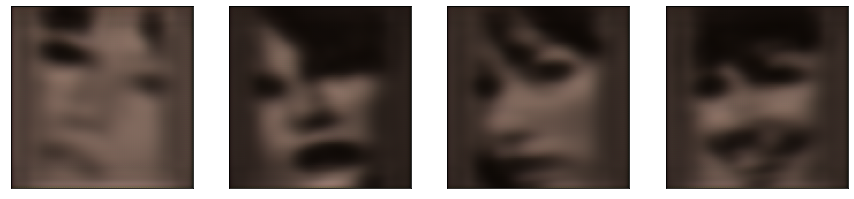

Masked Images


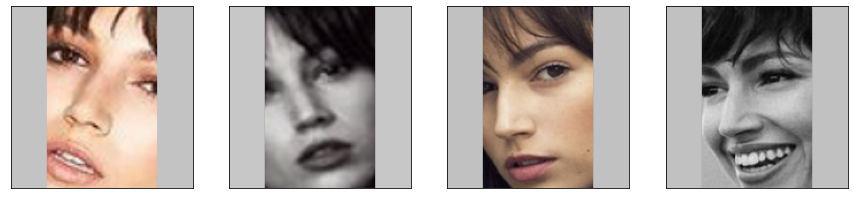

Actual Images


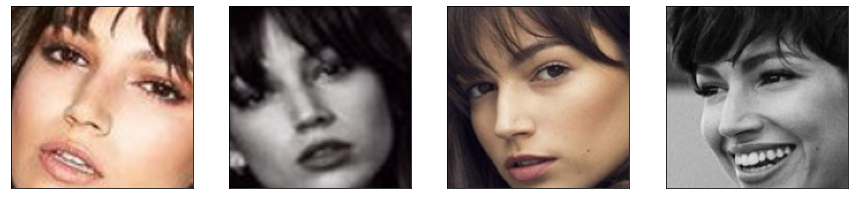

PSNR: 10.599030494689941
MSE: 0.09279743582010269
RMSE: 0.3046267032623291
Cosine Similarity: 0.986403226852417
Discriminator Prediction on Generator: 0.495353102684021
Discriminator Prediction on Actual: 0.4920090138912201
Epoch 2/80
[============]  MSE = 0.0502, Disc Loss = 1.3865, PSNR = 14.241, Test MSE = 0.1014, Test Disc Loss = 1.3932, Test PSNR = 10.443 
Time per epoch: 00:01:14

Epoch 3/80
[============]  MSE = 0.0336, Disc Loss = 1.3850, PSNR = 15.105, Test MSE = 0.0382, Test Disc Loss = 1.3894, Test PSNR = 14.619 
Time per epoch: 00:01:13

Epoch 4/80
[============]  MSE = 0.0288, Disc Loss = 1.3856, PSNR = 15.813, Test MSE = 0.0374, Test Disc Loss = 1.3899, Test PSNR = 14.664 
Time per epoch: 00:01:13

Test Images


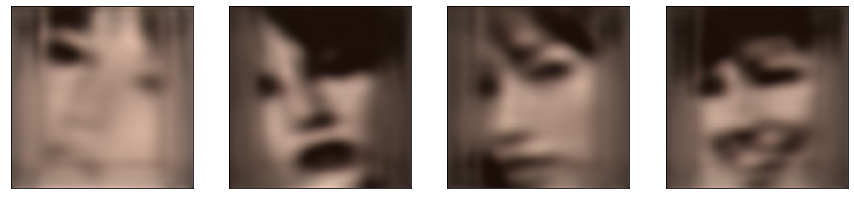

Masked Images


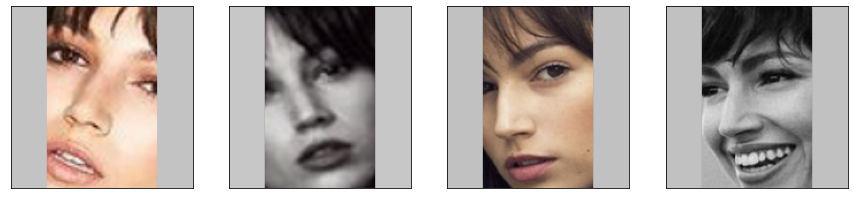

Actual Images


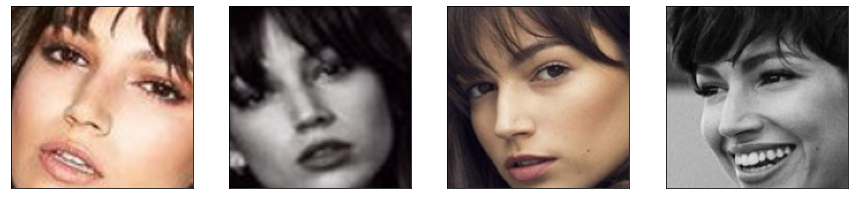

PSNR: 15.137643814086914
MSE: 0.03175457566976547
RMSE: 0.17819812893867493
Cosine Similarity: 0.9840590953826904
Discriminator Prediction on Generator: 0.49278178811073303
Discriminator Prediction on Actual: 0.4920090138912201
Epoch 5/80
[============]  MSE = 0.0262, Disc Loss = 1.3861, PSNR = 16.262, Test MSE = 0.0396, Test Disc Loss = 1.3909, Test PSNR = 14.370 
Time per epoch: 00:01:13

Epoch 6/80
[============]  MSE = 0.0245, Disc Loss = 1.3864, PSNR = 16.559, Test MSE = 0.0446, Test Disc Loss = 1.3916, Test PSNR = 13.891 
Time per epoch: 00:01:13

Epoch 7/80
[============]  MSE = 0.0233, Disc Loss = 1.3864, PSNR = 16.792, Test MSE = 0.0455, Test Disc Loss = 1.3917, Test PSNR = 13.837 
Time per epoch: 00:01:13

Test Images


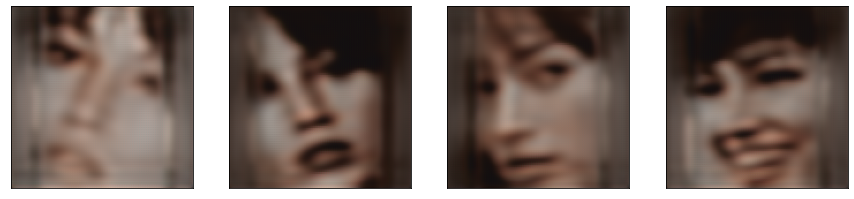

Masked Images


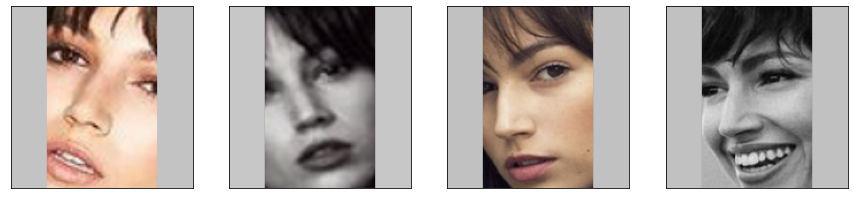

Actual Images


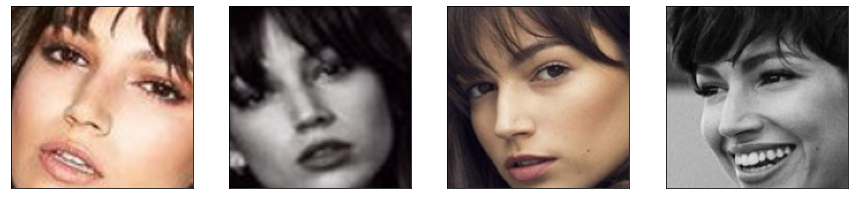

PSNR: 14.382593154907227
MSE: 0.03898416459560394
RMSE: 0.19744408130645752
Cosine Similarity: 0.9856833815574646
Discriminator Prediction on Generator: 0.49390217661857605
Discriminator Prediction on Actual: 0.4920090138912201
Epoch 8/80
[============]  MSE = 0.0221, Disc Loss = 1.3863, PSNR = 17.019, Test MSE = 0.0467, Test Disc Loss = 1.3918, Test PSNR = 13.754 
Time per epoch: 00:01:13

Epoch 9/80
[============]  MSE = 0.0212, Disc Loss = 1.3864, PSNR = 17.196, Test MSE = 0.0420, Test Disc Loss = 1.3913, Test PSNR = 14.283 
Time per epoch: 00:01:13

Epoch 10/80
[============]  MSE = 0.0204, Disc Loss = 1.3863, PSNR = 17.386, Test MSE = 0.0403, Test Disc Loss = 1.3910, Test PSNR = 14.491 
Time per epoch: 00:01:13

Test Images


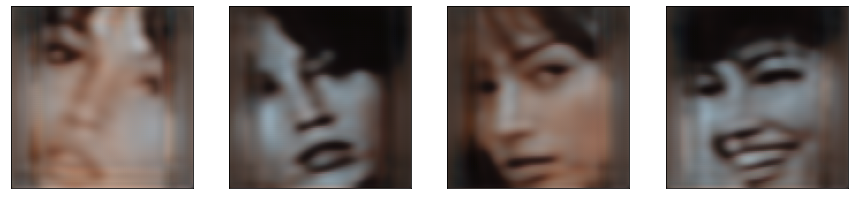

Masked Images


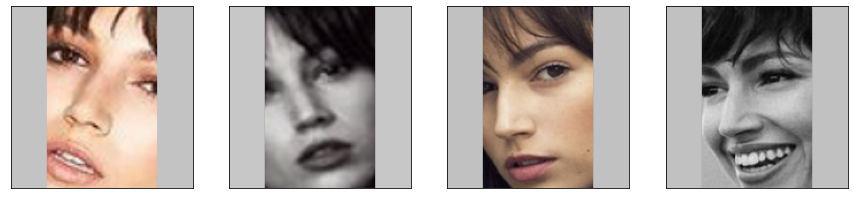

Actual Images


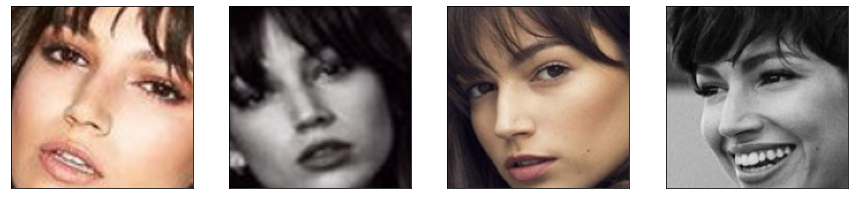

PSNR: 15.023136138916016
MSE: 0.034303490072488785
RMSE: 0.18521201610565186
Cosine Similarity: 0.9908351898193359
Discriminator Prediction on Generator: 0.4938499927520752
Discriminator Prediction on Actual: 0.4920090138912201
Epoch 11/80
[============]  MSE = 0.0195, Disc Loss = 1.3863, PSNR = 17.586, Test MSE = 0.0383, Test Disc Loss = 1.3907, Test PSNR = 14.709 
Time per epoch: 00:01:13

Epoch 12/80
[============]  MSE = 0.0188, Disc Loss = 1.3863, PSNR = 17.755, Test MSE = 0.0365, Test Disc Loss = 1.3904, Test PSNR = 14.947 
Time per epoch: 00:01:13

Epoch 13/80
[============]  MSE = 0.0183, Disc Loss = 1.3863, PSNR = 17.880, Test MSE = 0.0349, Test Disc Loss = 1.3901, Test PSNR = 15.166 
Time per epoch: 00:01:13

Test Images


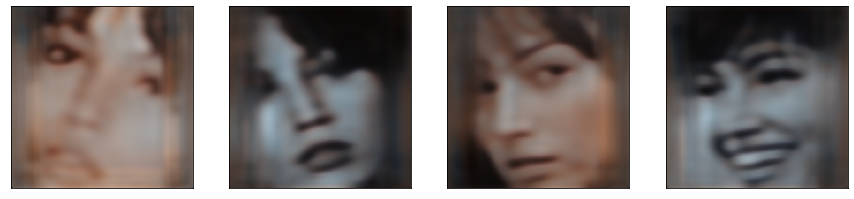

Masked Images


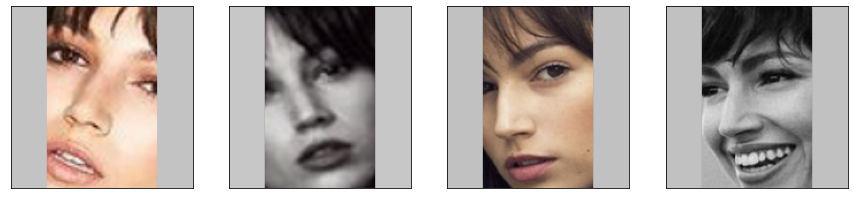

Actual Images


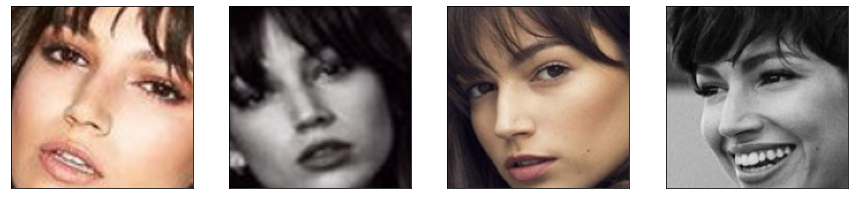

PSNR: 15.734668731689453
MSE: 0.029174789786338806
RMSE: 0.17080630362033844
Cosine Similarity: 0.9928244948387146
Discriminator Prediction on Generator: 0.49347931146621704
Discriminator Prediction on Actual: 0.4920090138912201
Epoch 14/80
[============]  MSE = 0.0179, Disc Loss = 1.3863, PSNR = 17.987, Test MSE = 0.0322, Test Disc Loss = 1.3897, Test PSNR = 15.564 
Time per epoch: 00:01:13

Epoch 15/80
[============]  MSE = 0.0176, Disc Loss = 1.3863, PSNR = 18.083, Test MSE = 0.0301, Test Disc Loss = 1.3893, Test PSNR = 15.916 
Time per epoch: 00:01:13

----------------Starting Phase 2----------------
Epoch 16/80
[============]  altered_MSE = 0.0179, Disc Loss = 0.8156, PSNR = 18.160, Test altered_MSE = 0.0287, Test Disc Loss = 0.7754, Test PSNR = 16.169 
Time per epoch: 00:02:00

Test Images


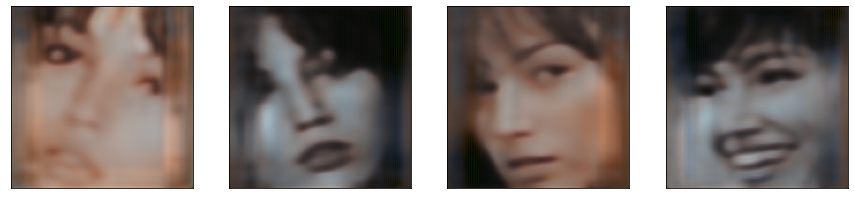

Masked Images


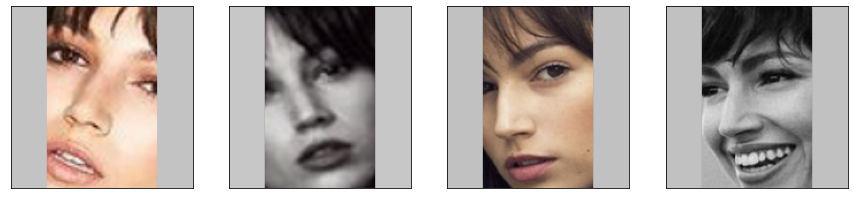

Actual Images


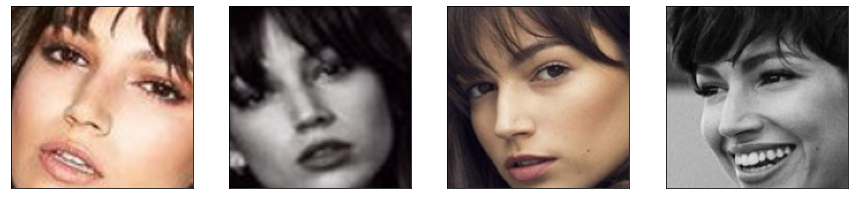

PSNR: 16.626760482788086
MSE: 0.023639025166630745
RMSE: 0.15374986827373505
Cosine Similarity: 0.9871248006820679
Discriminator Prediction on Generator: 0.47694477438926697
Discriminator Prediction on Actual: 0.8676122426986694
Epoch 17/80
[============]  altered_MSE = 0.0182, Disc Loss = 0.3857, PSNR = 18.183, Test altered_MSE = 0.0275, Test Disc Loss = 0.5525, Test PSNR = 16.410 
Time per epoch: 00:02:00

Epoch 18/80
[============]  altered_MSE = 0.0183, Disc Loss = 0.3370, PSNR = 18.217, Test altered_MSE = 0.0247, Test Disc Loss = 0.5096, Test PSNR = 16.956 
Time per epoch: 00:02:00

Epoch 19/80
[============]  altered_MSE = 0.0181, Disc Loss = 0.2985, PSNR = 18.290, Test altered_MSE = 0.0241, Test Disc Loss = 0.5178, Test PSNR = 17.142 
Time per epoch: 00:02:00

Test Images


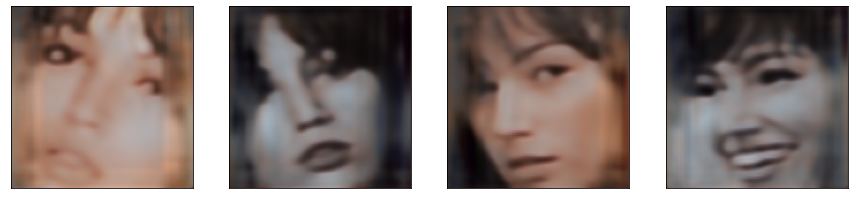

Masked Images


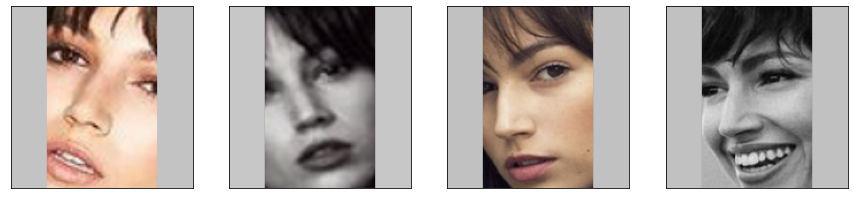

Actual Images


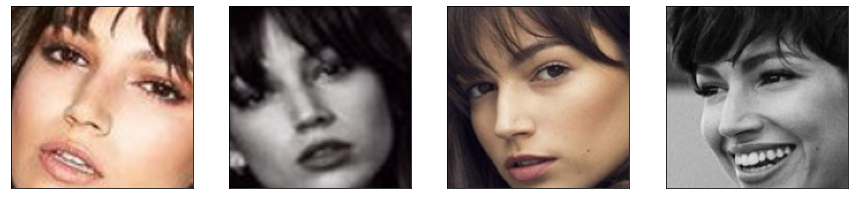

PSNR: 17.683027267456055
MSE: 0.018444761633872986
RMSE: 0.13581149280071259
Cosine Similarity: 0.9925059080123901
Discriminator Prediction on Generator: 0.2330399602651596
Discriminator Prediction on Actual: 0.9173959493637085
Epoch 20/80
[============]  altered_MSE = 0.0178, Disc Loss = 0.2966, PSNR = 18.379, Test altered_MSE = 0.0217, Test Disc Loss = 0.3713, Test PSNR = 17.582 
Time per epoch: 00:02:00

Epoch 21/80
[============]  altered_MSE = 0.0177, Disc Loss = 0.2708, PSNR = 18.416, Test altered_MSE = 0.0210, Test Disc Loss = 0.4950, Test PSNR = 17.743 
Time per epoch: 00:02:00

Epoch 22/80
[============]  altered_MSE = 0.0176, Disc Loss = 0.2874, PSNR = 18.437, Test altered_MSE = 0.0196, Test Disc Loss = 0.6144, Test PSNR = 17.971 
Time per epoch: 00:02:00

Test Images


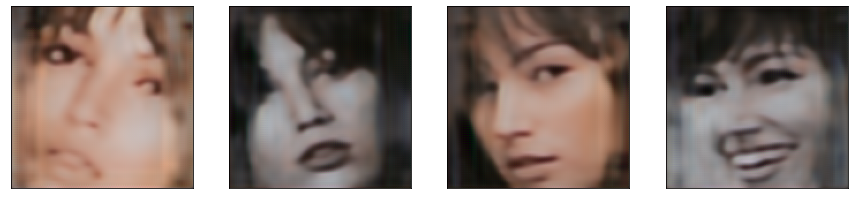

Masked Images


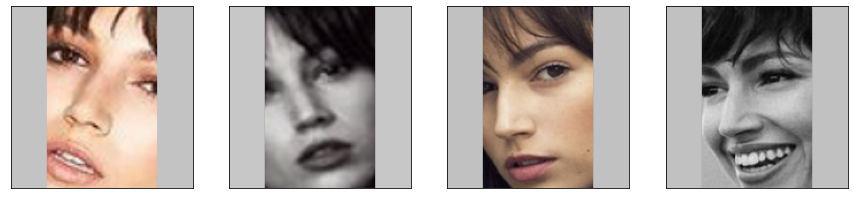

Actual Images


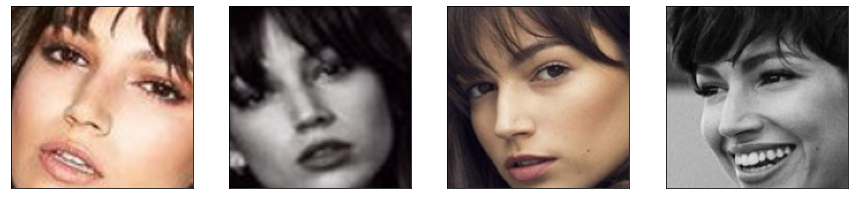

PSNR: 18.36315155029297
MSE: 0.015401112847030163
RMSE: 0.12410122156143188
Cosine Similarity: 0.9910840392112732
Discriminator Prediction on Generator: 0.39768898487091064
Discriminator Prediction on Actual: 0.9899522662162781
Epoch 23/80
[============]  altered_MSE = 0.0174, Disc Loss = 0.2784, PSNR = 18.495, Test altered_MSE = 0.0185, Test Disc Loss = 0.5317, Test PSNR = 18.232 
Time per epoch: 00:02:00

Epoch 24/80
[============]  altered_MSE = 0.0173, Disc Loss = 0.2744, PSNR = 18.541, Test altered_MSE = 0.0180, Test Disc Loss = 0.9010, Test PSNR = 18.334 
Time per epoch: 00:02:00

Epoch 25/80
[============]  altered_MSE = 0.0173, Disc Loss = 0.2769, PSNR = 18.544, Test altered_MSE = 0.0174, Test Disc Loss = 0.6399, Test PSNR = 18.519 
Time per epoch: 00:02:00

Test Images


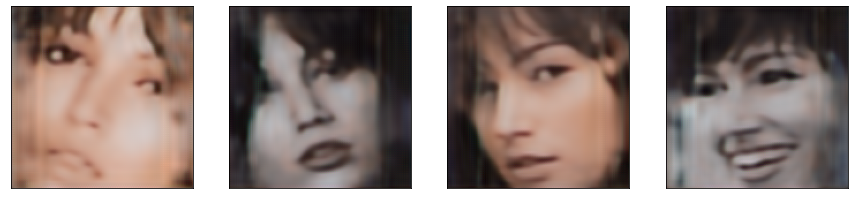

Masked Images


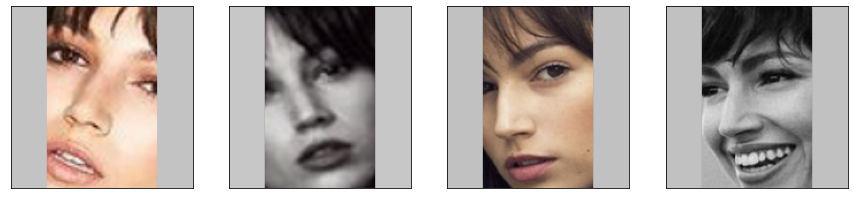

Actual Images


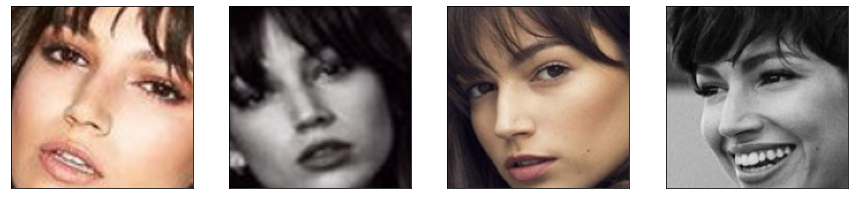

PSNR: 19.036745071411133
MSE: 0.012933336198329926
RMSE: 0.11372482776641846
Cosine Similarity: 0.9935687184333801
Discriminator Prediction on Generator: 0.43308407068252563
Discriminator Prediction on Actual: 0.992375373840332
Epoch 26/80
[============]  altered_MSE = 0.0172, Disc Loss = 0.2719, PSNR = 18.592, Test altered_MSE = 0.0170, Test Disc Loss = 0.4773, Test PSNR = 18.600 
Time per epoch: 00:02:00

Epoch 27/80
[============]  altered_MSE = 0.0170, Disc Loss = 0.2962, PSNR = 18.644, Test altered_MSE = 0.0164, Test Disc Loss = 0.6468, Test PSNR = 18.709 
Time per epoch: 00:02:00

Epoch 28/80
[============]  altered_MSE = 0.0169, Disc Loss = 0.2703, PSNR = 18.684, Test altered_MSE = 0.0165, Test Disc Loss = 0.4892, Test PSNR = 18.745 
Time per epoch: 00:02:00

Test Images


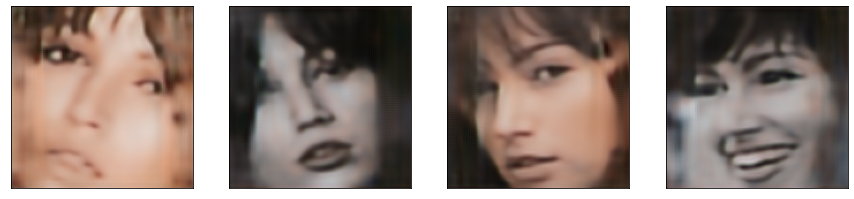

Masked Images


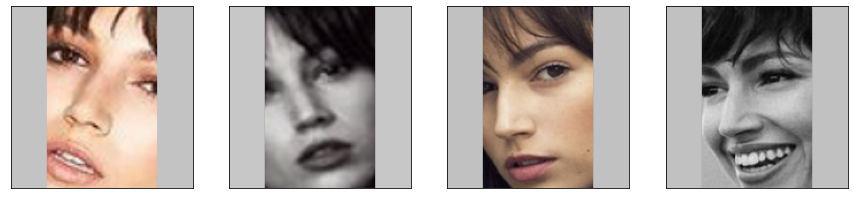

Actual Images


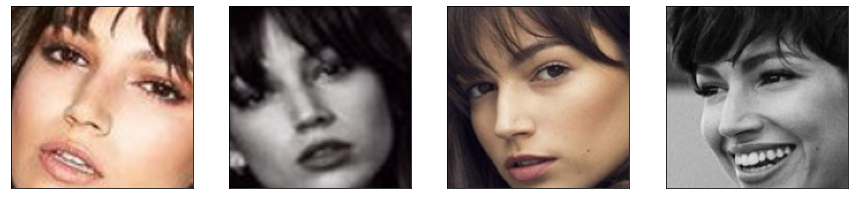

PSNR: 18.907196044921875
MSE: 0.01311615202575922
RMSE: 0.11452576518058777
Cosine Similarity: 0.9920624494552612
Discriminator Prediction on Generator: 0.41739344596862793
Discriminator Prediction on Actual: 0.9923548102378845
Epoch 29/80
[============]  altered_MSE = 0.0168, Disc Loss = 0.2823, PSNR = 18.721, Test altered_MSE = 0.0161, Test Disc Loss = 0.6911, Test PSNR = 18.877 
Time per epoch: 00:02:00

Epoch 30/80
[============]  altered_MSE = 0.0167, Disc Loss = 0.2734, PSNR = 18.760, Test altered_MSE = 0.0172, Test Disc Loss = 1.1660, Test PSNR = 18.495 
Time per epoch: 00:02:00

Epoch 31/80
[==

In [ ]:
# kwargs contain train_data = (masked_images, actual_images), test_data = (masked_test, actual_test),
#                    epochs, batch_size, 
#                    train_disc_after,
#                    loss=(gen_loss_function, disc_loss_function), 
#                    optimizer = (optimizer, optimizer),
#                    mask_compliment, accuracy_function,
#                    save_after, checkpoint_function,

train(gen_model, disc_model, 
      train_data=train_data,
      test_data = test_data,
      epochs=epochs, epochs_done=epochs_done, 
      train_disc_after=train_disc_after,
      batch_size=batch_size, 
      loss=(gen_loss, disc_loss), mse = mse_error,
      optimizer=(gen_optimizer, disc_optimizer), 
      mask_compliment=mask_compliment, 
      metric=accuracy_function,
      save_after=save_after, save_models=save_models,
      history=logs, save_logs=save_logs,
      plot_function=plot, plot_after=plot_after)

In [50]:
# Run this cell only if the above cell is interrupted or threw some error
# Load the logs of the completely trained model
logs = load_logs(logfile_name='logs_60epochs.pickle')

Log file loaded in the form of a dictionary


In [51]:
# Load the test set images required
with open('/content/image_data.pickle', 'rb') as file:
    images = joblib.load(file)[600: 630]

image_size, percent_crop = 224, 0.15
start_point = int(image_size*percent_crop)
end_point = image_size-start_point

images = images[:, start_point: end_point, start_point: end_point, :]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2
Generated Images


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


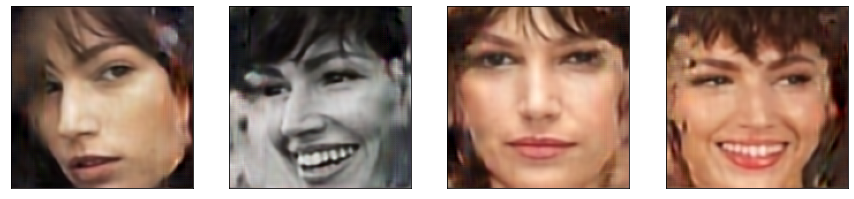

Masked Images


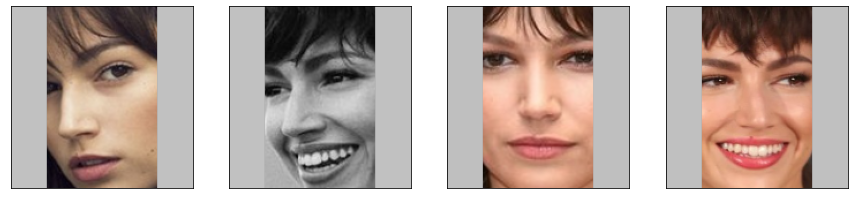

Actual Clear Images


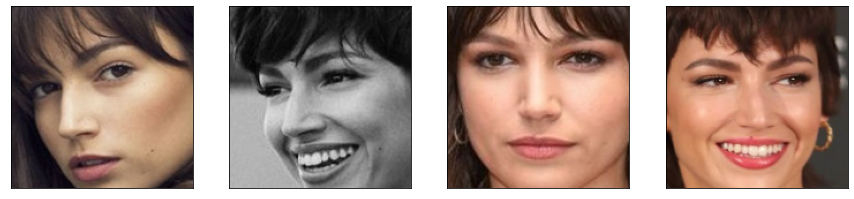

PSNR: 20.768035888671875
MSE: 0.008530832827091217
RMSE: 0.09236250950281544
Cosine Similarity: 0.9912316203117371
Discriminator Prediction on Generator: 0.1251918375492096
Discriminator Prediction on Actual: 0.5099995732307434
Generator Loss: 0.01026856992393732

Masked PSNR: 26.24349021911621
Masked mse: 0.008530832827091217
Masked RMSE: 0.09236250950281544
Masked Cosine Similarity: 0.9912316203117371


In [56]:
# 0.0327
# start = np.random.randint(600, 626)
# start = np.random.randint(0, 26)
count = 4
end = start + count
figsize = (15, 15)
percent_mask = 0.4
print_disc = True

print(start)
validation_dataset, validate_mask = create_masked_images(images[start: end], percent_mask = percent_mask, hide_axis=2, show_boundary=True)
validation_dataset = np.concatenate((validation_dataset, validate_mask), axis=3)

gen_imgs = gen_model.predict(validation_dataset)
try:
    validate_disk_masked = disc_model.predict(gen_imgs)
except ValueError:
    print_disc = False

print("Generated Images")
plot(gen_imgs, figsize=figsize)

print("Masked Images")
plot(validation_dataset, figsize=figsize)

print("Actual Clear Images")
plot(images[start: end], figsize=figsize)

print(f"PSNR: {psnr(images[start: end], gen_imgs)}")
print(f"MSE: {mse(images[start: end], gen_imgs)}")
print(f'RMSE: {rmse(images[start: end], gen_imgs)}')
print(f'Cosine Similarity: {cosine_sim(images[start: end], gen_imgs)}')

if print_disc:
    print(f'Discriminator Prediction on Generator: {tf.reduce_mean(validate_disk_masked)}')
    print(f'Discriminator Prediction on Actual: {tf.reduce_mean(disc_model.predict(images[start: end]))}')
    print(f'Generator Loss: {generator_loss(images[start: end], gen_imgs, validate_disk_masked, (1-validate_mask))}')

# Metrics on masked images
print()
print(f"Masked PSNR: {psnr((1-validate_mask)*images[start: end], (1-validate_mask)*gen_imgs)}")
print(f"Masked mse: {mse(images[start: end], gen_imgs)}")
print(f'Masked RMSE: {rmse(images[start: end], gen_imgs)}')
print(f'Masked Cosine Similarity: {cosine_sim(images[start: end], gen_imgs)}')

In [53]:
def plot_curve(train_data=None, validation_data=None, name='', xlabel='', ylabel=''):

    if train_data:
        plt.plot(train_data, label=f'Train {name}')
    
    if validation_data:
        plt.plot(validation_data, label=f'Test {name}')

    if xlabel:
        plt.xlabel(xlabel)
    
    if ylabel:
        plt.ylabel(ylabel)
    
    if name:
        plt.legend()

    plt.show()    

60


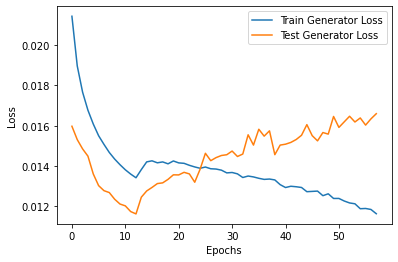

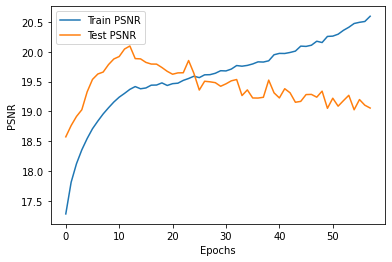

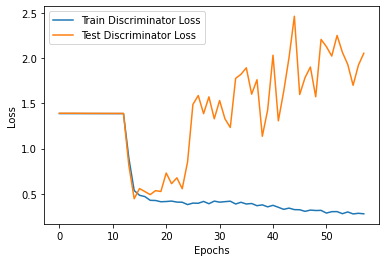

In [54]:
# First 10 epoch data not shown because of higher values of loss and lower valus PSNR initially
start, end = 0, len(logs['generator_loss'])
print(end)
plot_curve(logs['generator_loss'][start: end], logs['test_generator_loss'][start: end], name='Generator Loss', xlabel='Epochs', ylabel='Loss')
plot_curve(logs['psnr'][start: end], logs['test_psnr'][start: end], name='PSNR', xlabel='Epochs', ylabel='PSNR')
plot_curve(logs['discriminator_loss'][start: end], logs['test_discriminator_loss'][start: end], name='Discriminator Loss', xlabel='Epochs', ylabel='Loss')

In [ ]:
load_model('/Generator_100epochs.h5', custom_objects={'generator_loss':gen_loss})

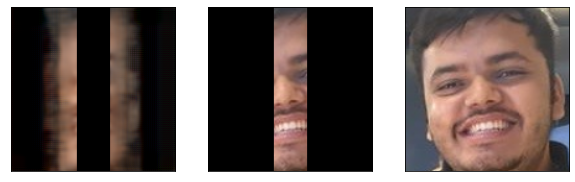

PSNR: 10.439781188964844
MSE: 0.09036948531866074
RMSE: 0.3006151729471878
Cosine Similarity: 0.8081144690513611

Discriminator Prediction on Generator: 0.9252352714538574
Discriminator Prediction on Actual: 0.7085595726966858



In [ ]:
test_img = cv2.imread('/profile_pic.jpg')
test_img = cv2.cvtColor(cv2.resize(test_img, (224, 224)), cv2.COLOR_BGR2RGB)
test_img = np.reshape(test_img/255, (1, 224, 224, 3))

test_img = test_img[:, 31: 189, 31: 189, :]

test_masked, test_mask = create_masked_images(test_img, percent_mask = 0.8, hide_axis=2)

test_figsize = (10, 10)
gen_test = gen_model.predict(test_masked)

plot([(1-test_mask)*gen_test[0], test_masked[0], test_img[0]], figsize=test_figsize)


print(f"PSNR: {psnr(test_img, gen_test)}")
print(f"MSE: {mse(test_img, gen_test)}")
print(f'RMSE: {rmse(test_img, gen_test)}')
print(f'Cosine Similarity: {cosine_sim(test_img, gen_test)}')

print()
print(f'Discriminator Prediction on Generator: {tf.reduce_mean(disc_model.predict(gen_test))}')
print(f'Discriminator Prediction on Actual: {tf.reduce_mean(disc_model.predict(test_img))}')

print()

In [ ]:
save_model(gen_model, f'Generator_200epochs.h5', include_optimizer=True, save_format='h5')
save_model(disc_model, f'Discriminator_200epochs.h5', include_optimizer=True, save_format='h5')

In [ ]:
noise_model.load_weights('/Image_Denoising_v9.5_Bucket6_120epochs.h5')